# Generative Adversarial Network (GAN) using Pytorch
A GAN trained on MNIST dataset to generate B/W handwritten digits. Both the Discriminator (C2 - C4 - C8), and the Generator (C32 - C16 - C8) are simple CNNs. The Generator latent space is 64 dimensional.

In [1]:
import torch
import torch.nn as nn
import torchvision as tv
import matplotlib.pyplot as plt

Download and load the dataset using `torchvision`

In [2]:
MNIST_dataset = tv.datasets.MNIST(root='./data', train=True, transform=tv.transforms.ToTensor(), download=True)
MNIST_loader = torch.utils.data.DataLoader(MNIST_dataset, batch_size=128, shuffle=True)

## Discriminator
Discriminator takes in a 28x28 images in and return a 0 for fake and 1 for real images. The weights are initiated using `kaiming_uniform_` for weights and zeros for the biases.

In [3]:
class MnistDisc(nn.Module):
    def __init__(self):
        super(MnistDisc, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, 1, 1, bias=True)
        self.a1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 4, 3, 1, 1, bias=True)
        self.a2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(4, 8, 3, 1, 0, bias=True)
        self.a3 = nn.ReLU()
        self.fc1 = nn.Linear(8*5*5, 1, bias=True)
        self._weight_init()

    def _weight_init(self):
        for layer in self.children():
            for name, _ in layer.named_parameters(recurse=False):
                if 'bias' in name:
                    nn.init.zeros_(layer.bias)
                else:
                    nn.init.kaiming_uniform_(layer.weight)
        return None
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.a1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.a2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.a3(x)
        x = x.flatten(start_dim=1, end_dim=-1)
        x = self.fc1(x)
        return x

## Generator
Generator takes in a 64x1 vector and outputs a 28x28 image. The weights are initiated using `kaiming_uniform_` for weights and zeros for the biases.

In [4]:
class MnistGen(nn.Module):
    def __init__(self, latent_dim):
        super(MnistGen, self).__init__()
        self.latent_dim = latent_dim

        self.fc1 = nn.Linear(self.latent_dim, 1568, bias=True) # 32*7*7 = 1568
        self.a1 = nn.LeakyReLU(0.2)
        self.usample1 = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(32, 16, 3, 1, 1, bias=True)
        self.a2 = nn.LeakyReLU(0.2)
        self.usample2 = nn.Upsample(scale_factor=2)
        self.conv2 = nn.Conv2d(16, 8, 3, 1, 1, bias=True)
        self.a3 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv2d(8, 1, 3, 1, 1, bias=True)
        self.a4 = nn.Sigmoid()
        self._weight_init()

    def _weight_init(self):
        for layer in self.children():
            for name, _ in layer.named_parameters(recurse=False):
                if 'bias' in name:
                    nn.init.zeros_(layer.bias)
                else:
                    nn.init.kaiming_uniform_(layer.weight)
        return None
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.a1(x)
        x = x.view(-1, 32, 7, 7) # Pytorch uses NCHW
        x = self.usample1(x)
        x = self.conv1(x)
        x = self.a2(x)
        x = self.usample2(x)
        x = self.conv2(x)
        x = self.a3(x)
        x = self.conv3(x)
        x = self.a4(x)
        return x

## GAN
Complete GAN model. Both discriminator and generator are using `Adam` optimizers. Discriminator is trying to minimize a binary cross-entropy loss on a set of fake and real images while the generator is trying to fool the discriminator by minimizing a binary cross-entropy loss on the fake images with labels of 1.

In [5]:
class MnistGAN(nn.Module):
    def __init__(self, latent_dim):
        super(MnistGAN, self).__init__()
        self._dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.latent_dim = latent_dim
        self.gen = MnistGen(self.latent_dim).to(self._dev)
        self.disc = MnistDisc().to(self._dev)
        self.d_loss_rep = {}
        self.g_loss_rep = {}

    def _disc_loss(self, data, z):
        gen_data = self.disc(self.gen(z))
        gen_label = torch.zeros((gen_data.shape[0], 1))
        real_data = self.disc(data)
        real_label = torch.ones((real_data.shape[0], 1))
        data = torch.concat([gen_data, real_data], axis=0)
        labels = torch.concat([gen_label, real_label], axis=0).to(self._dev) # For some reason colab put this on cpu...
        return torch.nn.BCEWithLogitsLoss(reduction='mean')(data, labels)

    def _gen_loss(self, z):
        gen_data = self.disc(self.gen(z))
        gen_label = torch.ones((gen_data.shape[0], 1)).to(self._dev)
        return torch.nn.BCEWithLogitsLoss(reduction='mean')(gen_data, gen_label)

    def _train_step(self, dopt, gopt, data, z):
        # step disc
        dopt.zero_grad()
        d_loss = self._disc_loss(data, z)
        d_loss.backward()
        dopt.step()
        dopt.zero_grad()
        # step gen
        gopt.zero_grad()
        g_loss = self._gen_loss(z)
        g_loss.backward()
        gopt.step()
        gopt.zero_grad()
        return d_loss, g_loss

    def train(self, data, epochs):
        dopt = torch.optim.Adam(self.disc.parameters(), lr=0.0002, weight_decay=0.0)
        dopt.zero_grad()
        gopt = torch.optim.Adam(self.gen.parameters(), lr=0.0002, weight_decay=0.0)
        gopt.zero_grad()

        for epoch in range(epochs):
            for id, batch in enumerate(data):
                batch, _ = batch
                batch = batch.to(self._dev)
                z = torch.randn((batch.shape[0], self.latent_dim)).to(self._dev)
                d_loss, g_loss = self._train_step(dopt, gopt, batch, z)
                
                if id ==0 and epoch % 10 == 0:
                    with torch.no_grad():
                        test_img = self.gen(z)[0:64, ...]
                        test_img = test_img.detach().cpu().numpy()
                    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
                    for i in range(8):
                        for j in range(8):
                            axs[i][j].imshow(test_img[i*8+j, 0, ...], cmap='gray')
                            axs[i][j].axis('off')
                    plt.show()
                
            with torch.no_grad():
              print(f'Epoch {epoch} d_loss: {d_loss} g_loss: {g_loss}')
              self.d_loss_rep[epoch] = d_loss.detach().cpu()
              self.g_loss_rep[epoch] = g_loss.detach().cpu()
        return None
    
    def plot_losses(self):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.plot(list(self.d_loss_rep.keys()), list(self.d_loss_rep.values()), color='b', lw=3, label='Discriminator Loss')
        ax.plot(list(self.g_loss_rep.keys()), list(self.g_loss_rep.values()), color='r', lw=3, label='Generator Loss')
        ax.legend()
        plt.show()
        return None

## Train
Create an instance of `MnistGAN` and train for 100 epochs

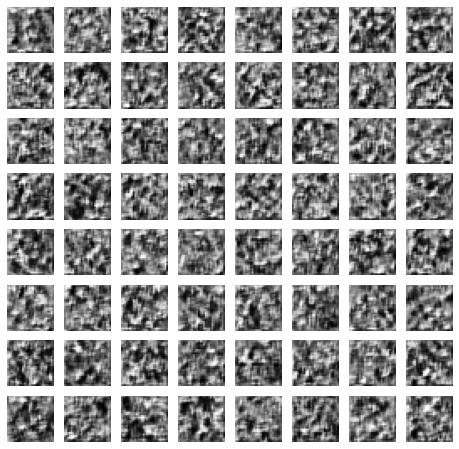

Epoch 0 d_loss: 0.6485780477523804 g_loss: 0.7522016763687134
Epoch 1 d_loss: 0.6884523630142212 g_loss: 0.7238950729370117
Epoch 2 d_loss: 0.6892194151878357 g_loss: 0.7378711700439453
Epoch 3 d_loss: 0.6990162134170532 g_loss: 0.6807066798210144
Epoch 4 d_loss: 0.685855507850647 g_loss: 0.6951016783714294
Epoch 5 d_loss: 0.6565179228782654 g_loss: 0.7840732336044312
Epoch 6 d_loss: 0.6379502415657043 g_loss: 0.80417799949646
Epoch 7 d_loss: 0.6109151244163513 g_loss: 0.8041088581085205
Epoch 8 d_loss: 0.6598877906799316 g_loss: 0.7585148215293884
Epoch 9 d_loss: 0.6698060035705566 g_loss: 0.7313603758811951


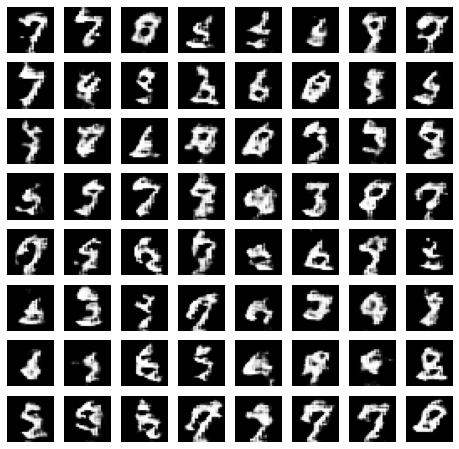

Epoch 10 d_loss: 0.7010281085968018 g_loss: 0.7356724739074707
Epoch 11 d_loss: 0.673445463180542 g_loss: 0.7305604815483093
Epoch 12 d_loss: 0.6886236071586609 g_loss: 0.7036282420158386
Epoch 13 d_loss: 0.6766278743743896 g_loss: 0.7358638644218445
Epoch 14 d_loss: 0.686530590057373 g_loss: 0.722825288772583
Epoch 15 d_loss: 0.6758326292037964 g_loss: 0.7317718267440796
Epoch 16 d_loss: 0.6886429190635681 g_loss: 0.7098691463470459
Epoch 17 d_loss: 0.6896014213562012 g_loss: 0.7145321369171143
Epoch 18 d_loss: 0.6918100118637085 g_loss: 0.7172054052352905
Epoch 19 d_loss: 0.6998594999313354 g_loss: 0.7101626396179199


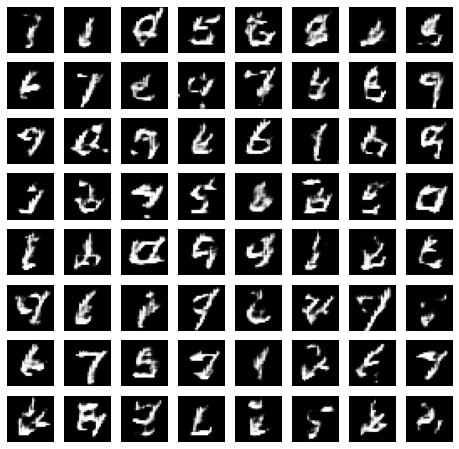

Epoch 20 d_loss: 0.6569793224334717 g_loss: 0.7305463552474976
Epoch 21 d_loss: 0.6985383033752441 g_loss: 0.7056069374084473
Epoch 22 d_loss: 0.6730846166610718 g_loss: 0.7432161569595337
Epoch 23 d_loss: 0.6669480204582214 g_loss: 0.7477283477783203
Epoch 24 d_loss: 0.6835055351257324 g_loss: 0.7292057871818542
Epoch 25 d_loss: 0.6822575330734253 g_loss: 0.7566168308258057
Epoch 26 d_loss: 0.6388692855834961 g_loss: 0.7760351896286011
Epoch 27 d_loss: 0.6614400148391724 g_loss: 0.7612895369529724
Epoch 28 d_loss: 0.6812245845794678 g_loss: 0.7272496223449707
Epoch 29 d_loss: 0.6791677474975586 g_loss: 0.723689079284668


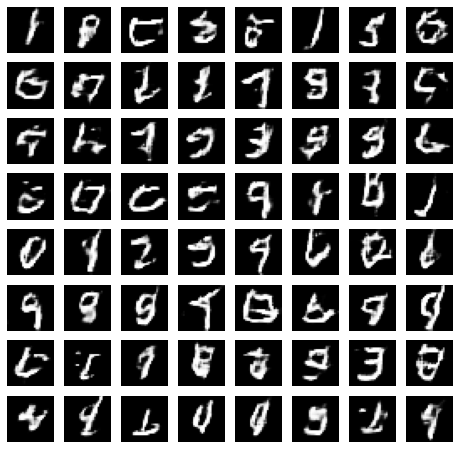

Epoch 30 d_loss: 0.670982301235199 g_loss: 0.7244181632995605
Epoch 31 d_loss: 0.6765622496604919 g_loss: 0.7337934970855713
Epoch 32 d_loss: 0.682927131652832 g_loss: 0.7276064157485962
Epoch 33 d_loss: 0.6832148432731628 g_loss: 0.7422035932540894
Epoch 34 d_loss: 0.6725592613220215 g_loss: 0.7317149639129639
Epoch 35 d_loss: 0.6786319017410278 g_loss: 0.7325959205627441
Epoch 36 d_loss: 0.6734555959701538 g_loss: 0.7287554144859314
Epoch 37 d_loss: 0.6891672015190125 g_loss: 0.7204439043998718
Epoch 38 d_loss: 0.6871412992477417 g_loss: 0.7093666791915894
Epoch 39 d_loss: 0.6935772895812988 g_loss: 0.6910165548324585


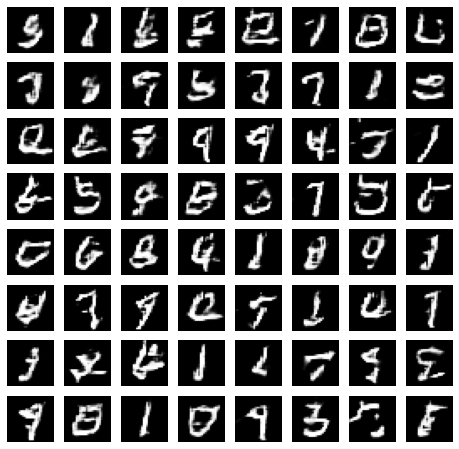

Epoch 40 d_loss: 0.6909466981887817 g_loss: 0.6842325925827026
Epoch 41 d_loss: 0.6874041557312012 g_loss: 0.7180086970329285
Epoch 42 d_loss: 0.688929557800293 g_loss: 0.7114616632461548
Epoch 43 d_loss: 0.6821671724319458 g_loss: 0.7116186022758484
Epoch 44 d_loss: 0.6862524747848511 g_loss: 0.7140340805053711
Epoch 45 d_loss: 0.700957179069519 g_loss: 0.701928973197937
Epoch 46 d_loss: 0.688593864440918 g_loss: 0.717086672782898
Epoch 47 d_loss: 0.7013632655143738 g_loss: 0.6853173971176147
Epoch 48 d_loss: 0.6986433863639832 g_loss: 0.6944713592529297
Epoch 49 d_loss: 0.6892876029014587 g_loss: 0.705980658531189


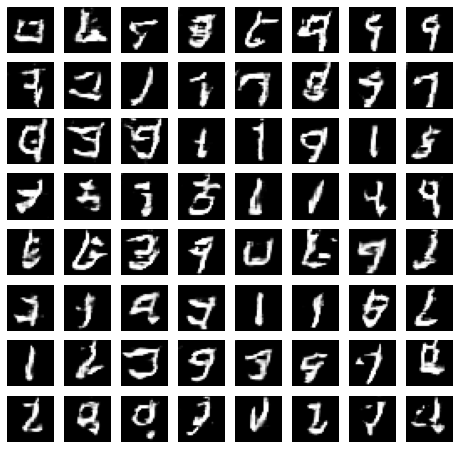

Epoch 50 d_loss: 0.6940031051635742 g_loss: 0.7005097270011902
Epoch 51 d_loss: 0.6863026022911072 g_loss: 0.6996328830718994
Epoch 52 d_loss: 0.6932128667831421 g_loss: 0.7160335779190063
Epoch 53 d_loss: 0.6916271448135376 g_loss: 0.6874615550041199
Epoch 54 d_loss: 0.694756031036377 g_loss: 0.6991564631462097
Epoch 55 d_loss: 0.6910375356674194 g_loss: 0.6987200975418091
Epoch 56 d_loss: 0.6942825317382812 g_loss: 0.7009987831115723
Epoch 57 d_loss: 0.6845401525497437 g_loss: 0.7032710909843445
Epoch 58 d_loss: 0.6870893836021423 g_loss: 0.6958874464035034
Epoch 59 d_loss: 0.6859309077262878 g_loss: 0.7232736349105835


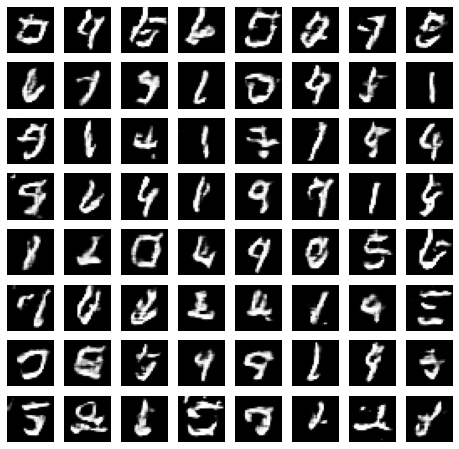

Epoch 60 d_loss: 0.7024054527282715 g_loss: 0.6820828318595886
Epoch 61 d_loss: 0.6940585374832153 g_loss: 0.7135906219482422
Epoch 62 d_loss: 0.6810868978500366 g_loss: 0.6960186958312988
Epoch 63 d_loss: 0.6846703290939331 g_loss: 0.7180240154266357
Epoch 64 d_loss: 0.686234176158905 g_loss: 0.7006220817565918
Epoch 65 d_loss: 0.6846020221710205 g_loss: 0.7163393497467041
Epoch 66 d_loss: 0.6732491850852966 g_loss: 0.7232170104980469
Epoch 67 d_loss: 0.6740862727165222 g_loss: 0.7187203168869019
Epoch 68 d_loss: 0.6798123121261597 g_loss: 0.7215187549591064
Epoch 69 d_loss: 0.6792826652526855 g_loss: 0.6985151171684265


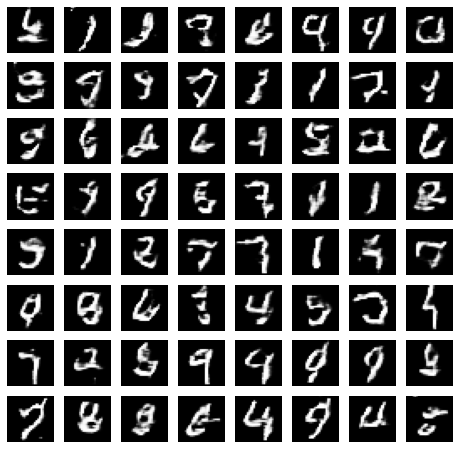

Epoch 70 d_loss: 0.6863435506820679 g_loss: 0.7017032504081726
Epoch 71 d_loss: 0.68773353099823 g_loss: 0.7183693647384644
Epoch 72 d_loss: 0.6963348388671875 g_loss: 0.7013301849365234
Epoch 73 d_loss: 0.6840218305587769 g_loss: 0.7298096418380737
Epoch 74 d_loss: 0.690156102180481 g_loss: 0.7231550216674805
Epoch 75 d_loss: 0.6715773344039917 g_loss: 0.7221243381500244
Epoch 76 d_loss: 0.6756956577301025 g_loss: 0.7319411039352417
Epoch 77 d_loss: 0.6961846351623535 g_loss: 0.6878620982170105
Epoch 78 d_loss: 0.6796663999557495 g_loss: 0.7506222724914551
Epoch 79 d_loss: 0.686761736869812 g_loss: 0.6927801966667175


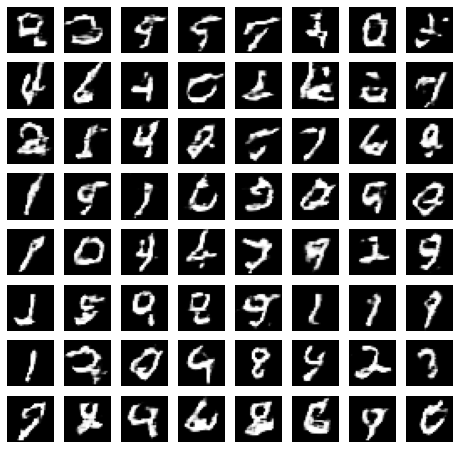

Epoch 80 d_loss: 0.6844978332519531 g_loss: 0.7262144088745117
Epoch 81 d_loss: 0.6977419257164001 g_loss: 0.6964038610458374
Epoch 82 d_loss: 0.6981098651885986 g_loss: 0.6957459449768066
Epoch 83 d_loss: 0.6879727840423584 g_loss: 0.7090474963188171
Epoch 84 d_loss: 0.6872233152389526 g_loss: 0.7060720324516296
Epoch 85 d_loss: 0.692112922668457 g_loss: 0.6976636648178101
Epoch 86 d_loss: 0.6941540241241455 g_loss: 0.7625274658203125
Epoch 87 d_loss: 0.6772499084472656 g_loss: 0.6787886023521423
Epoch 88 d_loss: 0.6920161247253418 g_loss: 0.7185031771659851
Epoch 89 d_loss: 0.6989328861236572 g_loss: 0.6862057447433472


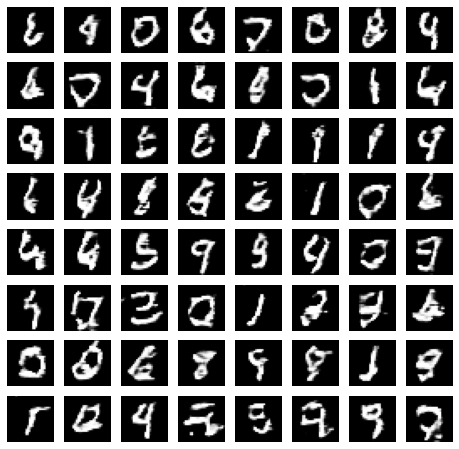

Epoch 90 d_loss: 0.6947988271713257 g_loss: 0.6914293169975281
Epoch 91 d_loss: 0.6902785301208496 g_loss: 0.6965928077697754
Epoch 92 d_loss: 0.6899344325065613 g_loss: 0.6712754964828491
Epoch 93 d_loss: 0.6974579691886902 g_loss: 0.6975995898246765
Epoch 94 d_loss: 0.6916999816894531 g_loss: 0.7140560150146484
Epoch 95 d_loss: 0.689084529876709 g_loss: 0.7124918699264526
Epoch 96 d_loss: 0.6931003928184509 g_loss: 0.7025169134140015
Epoch 97 d_loss: 0.6996632814407349 g_loss: 0.6916472315788269
Epoch 98 d_loss: 0.6850188970565796 g_loss: 0.7027521133422852
Epoch 99 d_loss: 0.6962982416152954 g_loss: 0.7122730612754822


In [6]:
model = MnistGAN(64)
model.train(MNIST_loader, 100)

## Plot the losses
Plot the discriminator and generator losses. The initial dip in the discriminator loss and subsequent increase of it is visible. This is due to generator getting better at tricking the discriminator.

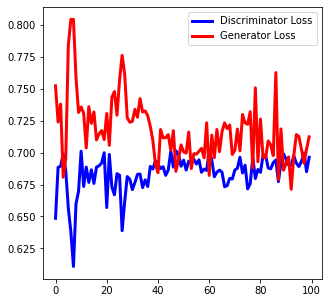

In [7]:
model.plot_losses()